# 1. Imports

In [1]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm, gamma
from scipy import interpolate, optimize, integrate

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random
import itertools
import time

from W_Stress import W_Stress
from helper import create_u_grid

In [2]:
from IPython.display import display

In [3]:
# Set random seed
np.random.seed(1)

# Set folder to save results
folder = 'Plots/ex/'

# 2. Generating Data - The Baseline Model

We consider a spatial model for modelling insurance portfolio losses, where each individual loss occurs at different locations and the dependence between individual losses is a function of the distance between the locations of the losses. 

The locations $z_m = (z^1_m, z^2_m)$ for $m = 1, ..., 10$ are randomly selected, where $z^i_m \sim Unif(0,1)$ for $i=1,2$. The insurance loss at location $m$, denoted by $L_m$, follows a $Gamma(5, 0.2m)$ distribution with location parameter $25$. The losses $L_1, ..., L_m$ have, conditionally on $\Theta = \theta$, a Gaussian copula with correlation matrix $\Omega$ given by $\rho_{i,j} =$ Cor$(L_i,L_j) = e^{-\theta \lVert z_i - z_j \lVert}$, where $\lVert \cdot \lVert$ is the Euclidean distance. The parameter $\Theta$ takes values (0, 0.4, 5) with probabilities (0.05, 0.6, 0.35), corresponding to different regimes. 

Lastly, we calculate the total loss of the insurance company by $Y = \sum_{m=1}^{10} L_m$.

In [4]:
def generate_spatial_data(Nsims, plot=True):
    # Get z1, ... , z10 where zi = (zi(1), zi(2)) and zi(1), zi(2) ~ U(0,1)
    z1 = np.random.uniform(size=10)
    z2 = np.random.uniform(size=10)
    z = list(zip(z1, z2))

    # Get theta in (0, 0.4, 5) with probabilities (0.05, 0.6, 0.35)
    x = np.random.uniform(0, 1, size=Nsims)
    thetas = np.zeros(Nsims)

    thetas[np.where(x <= 0.05)] = 0
    thetas[np.where((0.05 < x) & (x <= 0.65))] = 0.4
    thetas[np.where(x > 0.65)] = 5

    # Generate realizations of (L1, ..., L10) using Gaussian copulas
    x = np.zeros((Nsims, 10))
    theta_labels = {5:[], 0.4:[], 0: []}
    for i in range(Nsims):
        theta = thetas[i]
        # Get the correlation
        # rho_ij = exp{-theta_i * ||zi - zj||} where ||.|| denotes the Euclidean distance
        Omega = np.zeros((10, 10))
        for j in range(10):
            for k in range(10):
                Omega[j, k] = np.exp(-theta * np.linalg.norm(np.array(z[j]) - np.array(z[k])))

        # Create samples from a correlated multivariate normal
        x0 = np.random.multivariate_normal(mean=np.zeros(10), cov=Omega)
        x[i, :] = x0
        theta_labels[theta].append(i)

    # Get uniform marginals
    u = norm.cdf(x)

    # Marginal distributions Li ~ Gamma(5, 0.2i) with mean=25
    L = np.zeros((Nsims, 10))
    x_axis = np.linspace(25, 50, 200)
    means = np.zeros(10)
    for i in range(10):
        L_i = gamma.ppf(u[:, i], a=5, loc=25, scale=0.2*(i+1))
        L[:, i] = L_i

        means[i] = np.mean(L_i)

        # Gamma distribution plot
        if plot:
            y_i = gamma.pdf(x_axis, a=5, loc=25, scale=0.2*(i+1))
            plt.plot(x_axis, y_i, label=f"scale={0.2*(i+1)}")
    if plot:
        plt.legend()
        plt.show()

    max_mean = np.max(means)
    min_mean = np.min(means)
    marker_sizes = (means - min_mean)/(max_mean - min_mean)*150

    # Location plot
    if plot:
        plt.scatter(z1, z2, marker='o', color='black', s=marker_sizes)
        plt.show()

    # Define the data and get the bandwidths, density and CDF
    data = {"y": np.sum(L, axis=1), "x": L}

    return data, theta_labels

In [5]:
# Generate data (spatial)
data, theta_labels = generate_spatial_data(1000, plot=False)

# Define the gridspace
u = create_u_grid([0.005, 0.95])

# Generate the baseline model
brackets = [200, 450]
StressModel = W_Stress(data, u, brackets)

#### Visualization of Baseline Model

We examine the loss at two locations, $z_2$ and $z_9$. The scatterplot shows the positive correlation between $L_2$ and $L_9$, and how the correlation changes with the parameter $\Theta$. $\Theta = 0$ corresponds to a correlation of 1 between the losses, independent of their location, while larger values of $\Theta$ correspond to smaller, albeit still positive, correlation.


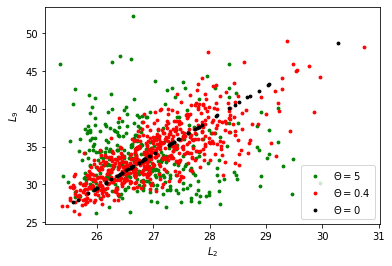

In [6]:
# Select specific (Li, Lj) to plot
i = 1
j = 8

# Visualize the data
colors = {0: 'black', 0.4: 'red', 5:'green'}

# Pair-wise scatterplot
for theta in theta_labels.keys():
    row_idx = theta_labels[theta]
    plt.scatter(data['x'][row_idx, i], data['x'][row_idx, j], color=colors[theta],
                s=8, label=f"$\Theta={theta}$")
plt.xlabel(f"$L_{i+1}$")
plt.ylabel(f"$L_{j+1}$")
plt.legend()
plt.show()

# 3. Calculating Stressed Models

Next, we apply the different stresses to the portfolio loss $Y$ and optimise for the distribution function $G^*_Y$ that satisfies the stress and is closest in the 2-Wasserstein distance. 

### 3a. Example: Stress alpha-beta risk measure

#### The alpha-beta Risk Measure

The distortion risk measure $\rho_{\gamma}$ with distortion weight function $\gamma$ is defined as

\begin{equation}
\rho_{\gamma}(G_Y) = \int_0^1 \breve{G}_Y(u) \gamma(u) du
\end{equation}

where $G_Y$ is a distribution function for $Y$, $\gamma \in \mathbb{L}^2([0,1])$ is a square-integrable function with $\gamma: [0,1] \to [0,1]$ and $\int_0^1 \gamma(u) du = 1$.

The $\alpha-\beta$ risk measure, $0 < \beta \leq \alpha < 1$, is defined by 
\begin{equation}
\gamma(u) = \frac{1}{\eta}(p\mathbb{1}_{\{u < \beta\}} + (1-p)\mathbb{1}_{\{u \geq \alpha\}})
\end{equation}

for $p \in [0, 1]$ with normalising constant $\eta = p \beta + (1-p)(1-\alpha)$.

The $\gamma(u)$ for $\alpha=0.9$, $\beta=0.1$, and $p \in \{0.25, 0.5, 0.75\}$ are plotted below.

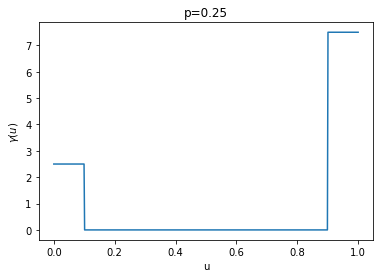

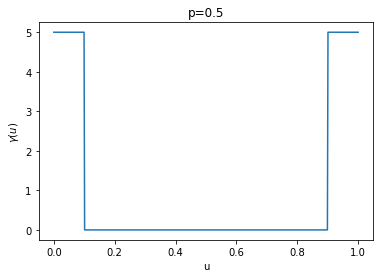

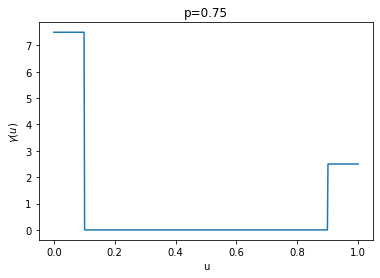

In [7]:
# set alpha, beta, p levels
p_list = [0.25, 0.5, 0.75]
alpha = 0.9
beta = 0.1

for p in p_list:
    # Plot the alpha-beta gamma function
    alpha_beta_gamma = [lambda u: ((u < beta) * p + (u >= alpha) * (1 - p)) / (p * beta + (1 - p) * (1 - alpha))]

    plt.plot(u, alpha_beta_gamma[0](u))
    plt.ylabel(r'$\gamma(u)$')
    plt.xlabel('u')
    plt.title(f'p={p}')
    plt.show()

#### The Stressed Distribution

We apply a stress of $10\%$ to the $\alpha-\beta$ risk measure. For each $p \in \{0.25, 0.5, 0.75\}$ we plot first, the stressed and baseline quantile functions of the output and second, the corresponding densities.


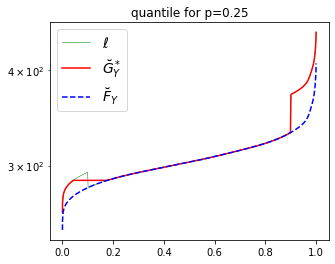

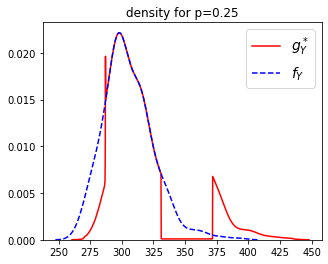

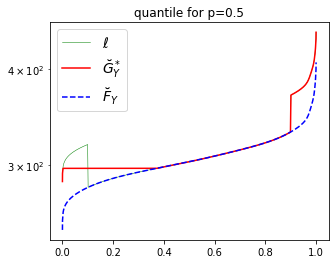

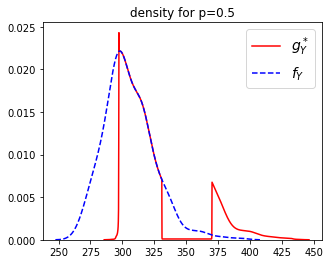

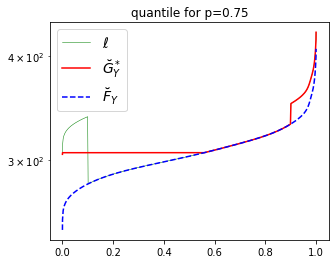

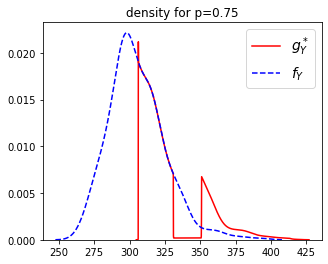

In [8]:
# Create dictionary to store results
stressed_models = {}

for p in p_list:
    # Set the alpha-beta gamma function
    alpha_beta_gamma = [lambda u: ((u < beta) * p + (u >= alpha) * (1 - p)) / (p * beta + (1 - p) * (1 - alpha))]
    StressModel.set_gamma(alpha_beta_gamma)

    # Compute the risk-measure of the base model
    RM_P = StressModel.get_risk_measure_baseline()
    
    # Run optimization
    lam, WD, RM_Q, fig = StressModel.optimise_rm(RM_P * np.array([1.1]), title=f"quantile for p={p}")
    
    # Save the StressModel object
    stressed_models[p] = copy.copy(StressModel)
    
    # Generate filename
    filename = folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_p_{p}_10'
    
    # Plot quantile functions
    display(fig)
    # fig.savefig(filename + '_inv.pdf', format='pdf')

    # Plot result distributions
    StressModel.plot_dist(filename, type="ES", title=f"density for p={p}", cdf=False, save=False)

#### The Stressed Model

We examine how the stress applied to the $\alpha-\beta$ risk measure affects the distributions of the input parameters $L_2$ and $L_9$. For each $p \in \{0.25, 0.5, 0.75\}$ we plot first, the stressed and baseline density functions of the input parameters and second, the contours for the stressed and baseline bivariate copulae of $(L_2, L_9)$, where the baseline contours are semi-transparent. 

p=0.25


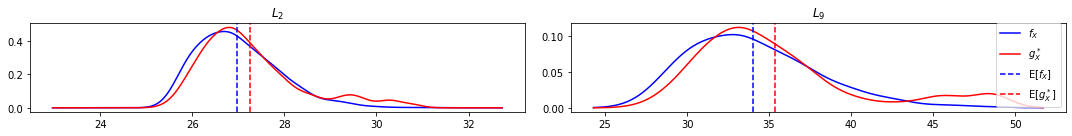

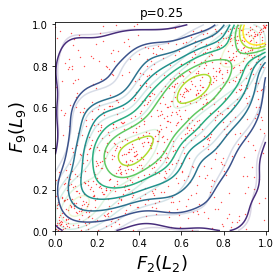

p=0.5


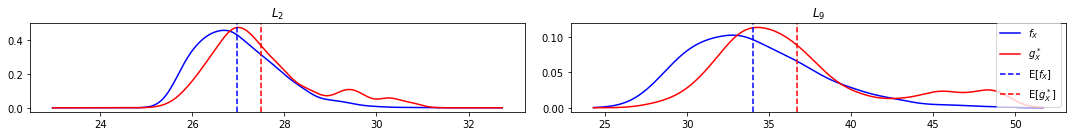

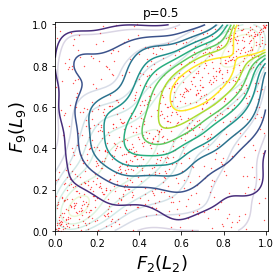

p=0.75


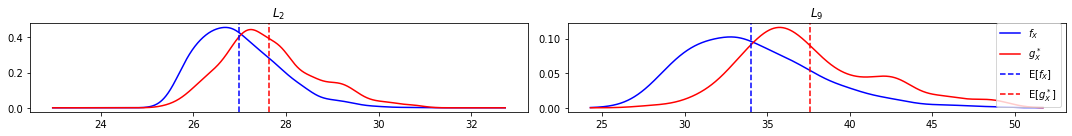

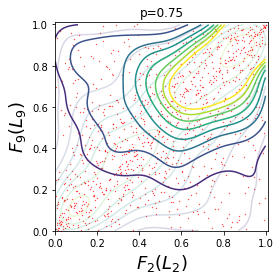

In [9]:
# Select specific (Li, Lj) to plot
i = 1
j = 8

# Plot x-density and copulae
for key in stressed_models:
    model = stressed_models[key]

    # Generate filename
    filename = folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_p_{key}_10'
    # fig.savefig(filename + '_inv.pdf', format='pdf')
      
    # Plot density of Li, Lj
    print(f'p={key}')
    model.plot_xdensity(filename, inputs = [i, j], save=False)
    
    # Plot copula contours for selected (Li, Lj)
    model.plot_copula(i, j, filename + f'_copula_L{i}_L{j}.pdf',
                            save=False, title=f'p={key}')

#### Sensitivity Measures
The reverse sensitivity measure quantifies the variability of each input factor's distribution from the baseline to the stressed model. For a function $s: \mathbb{R} \to \mathbb{R}$, the reverse sensitivity measure to input $L_i$ with respect to a stressed probability measure $\mathbb{Q}^*$ is defined by

$S_i^{\mathbb{Q}^*} = \begin{cases}
 \frac{\mathbb{E}^{\mathbb{Q}^*}[s(L_i)] - \mathbb{E}[s(L_i)]}{\max_{\mathbb{Q} \in Q}\mathbb{E}^{\mathbb{Q}}[s(L_i)] - \mathbb{E}[s(L_i)]} \quad \quad & \mathbb{E}^{\mathbb{Q}^*}[s(L_i)] \geq \mathbb{E}[s(L_i)] \\
-\frac{\mathbb{E}^{\mathbb{Q}^*}[s(L_i)] - \mathbb{E}[s(L_i)]}{\min_{\mathbb{Q} \in Q}\mathbb{E}^{\mathbb{Q}}[s(L_i)] - \mathbb{E}[s(L_i)]} & \textrm{otherwise,}
\end{cases}$

where Q = {$\mathbb{Q}$ | $\mathbb{Q}$ probability measure with $\frac{d\mathbb{Q}}{d\mathbb{P}} \stackrel{\mathbb{P}}{=} \frac{d\mathbb{Q}^*}{d\mathbb{P}}$} is the set of all probability measures whose RN-derivative have the same distribution as $\frac{d\mathbb{Q}^*}{d\mathbb{P}}$ under $\mathbb{P}$.

We use $s(L_i) = L_i$, $s(L_i) = \mathbb{1}_{\{L_i > \breve{F_i}(0.10)\}}$ and $s(L_i) = \mathbb{1}_{\{L_i > \breve{F_i}(0.90)\}}$. The plots below show the reverse sensitivity measures for each input $L_i$ under the different $s$ and $p$.

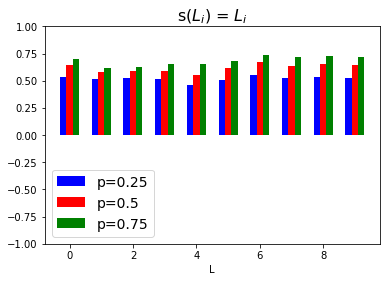

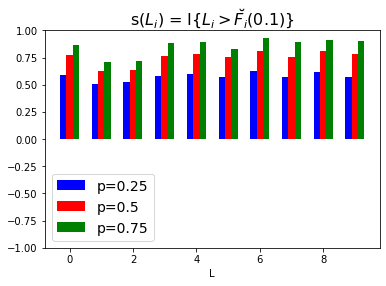

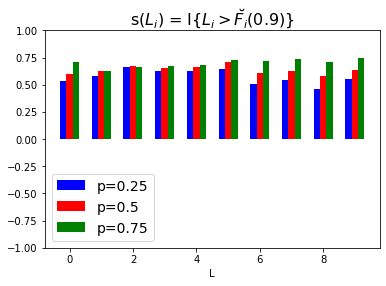

In [10]:
# Initialize sensitivity results lists
sensitivity_measures_s = []
sensitivity_measures_10 = []
sensitivity_measures_90 = []
labels = []
colors = ['blue', 'red', 'green']

# Get sensitivities
for key in stressed_models:
    model = stressed_models[key]
    
    # Calculate sensitivity_measures
    S90 = np.zeros(10)
    S10 = np.zeros(10)
    for k in range(10):
        # Get s:R->R
        s90 = lambda x: x > gamma.ppf(0.9, a=5, loc=25, scale=0.2 * (k + 1))
        s10 = lambda x: x > gamma.ppf(0.1, a=5, loc=25, scale=0.2 * (k + 1))
        S90[k] = model.reverse_sensitivity_measure(s90, StressModel.data['x'][:, k])
        S10[k] = model.reverse_sensitivity_measure(s10, StressModel.data['x'][:, k])
    Ss = model.reverse_sensitivity_measure(lambda x: x, StressModel.data['x'])

    sensitivity_measures_s.append(Ss)
    sensitivity_measures_10.append(S10)
    sensitivity_measures_90.append(S90)

    labels.append(f'p={key}')

# Plot sensitivities
StressModel.plot_sensitivities(sensitivity_measures_s, labels=labels, colors=colors,
                           title=r's($L_i$) = $L_i$', save=False,
                           filename=folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_10_sensitivity.pdf')
StressModel.plot_sensitivities(sensitivity_measures_10, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.1)$}', save=False,
                           filename=folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_10_sensitivity_80.pdf')
StressModel.plot_sensitivities(sensitivity_measures_90, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.9)$}', save=False,
                           filename=folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_10_sensitivity_95.pdf')

### 3b. Example: Stress ES risk measure + mean & standard deviation

#### The Stressed Distribution

The expected shortfall risk measure ($ES_{\alpha}$) is a special instance of the $\alpha-\beta$ risk measure when $p=0$. We set $\alpha = 0.95$ and apply a $5\%$ stress to the $ES_{0.95}$, a $-5\%$ stress to the mean, and a $2\%$ stress to the standard deviation. We plot first, the stressed and baseline quantile functions of the output and second, the corresponding densities.

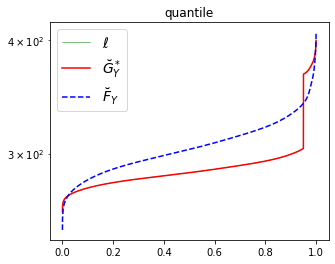

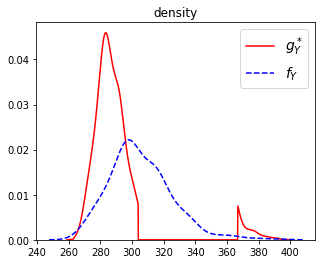

In [11]:
# Set alpha, gammas
alpha = 0.95
gamma_ES = [lambda u: (u >= alpha) / (1 - alpha)]
StressModel.set_gamma(gamma_ES)

# Set stresses
rm_stress = 5
mean_stress = -5
std_stress = 2

# Compute the risk-measure, mean, and standard deviation of the base model
RM_P = StressModel.get_risk_measure_baseline()
mean_P, std_P = StressModel.get_mean_std_baseline()

# Run optimization
_, _, _, _, fig = StressModel.optimise_rm_mean_std(np.array([1 + rm_stress / 100]) * RM_P,
                                                      (1 + mean_stress / 100) * mean_P,
                                                      (1 + std_stress / 100) * std_P,
                                                  title=f"quantile")

filename = folder + f'ES-mean-std/data_alpha_{alpha}_ES_{rm_stress}_M_{mean_stress}_S_{std_stress}'

# Plot quantile function
display(fig)

# Plot result distributions
StressModel.plot_dist(filename, type="ES", title=f"density", cdf=False, save=False)

#### The Stressed Model

We examine how the stresses applied affects the distributions of the input parameters $L_2$ and $L_9$. We plot first, the stressed and baseline density functions of the input parameters and second, the contours for the stressed and baseline bivariate copulae of $(L_2, L_9)$, where the baseline contours are semi-transparent. 

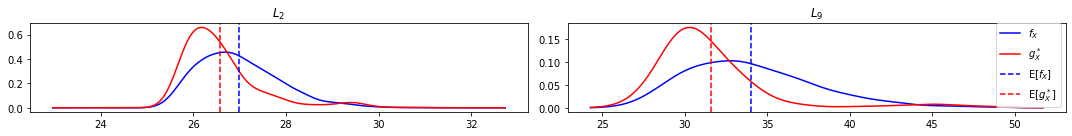

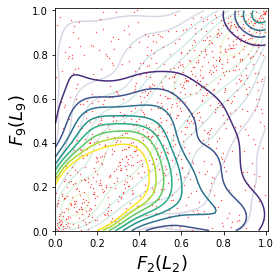

In [12]:
# Select specific (Li, Lj) to plot
i = 1
j = 8

# Plot density of Li, Lj
StressModel.plot_xdensity(filename, inputs = [i, j], save=False)

# Plot copula contours for selected (Li, Lj)
StressModel.plot_copula(i, j, filename + f'_copula_L{i}_L{j}.pdf', save=False)

#### Sensitivity Measures

We use $s(L_i) = L_i$ and $s(L_i) = \mathbb{1}_{\{L_i > \breve{F_i}(0.95)\}}$. The plots below show the reverse sensitivity measures for each input $L_i$ under the different $s$.

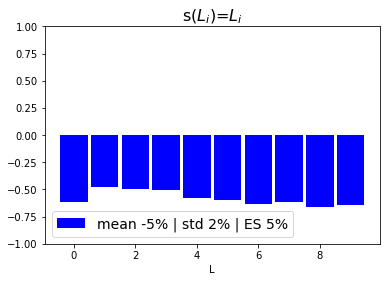

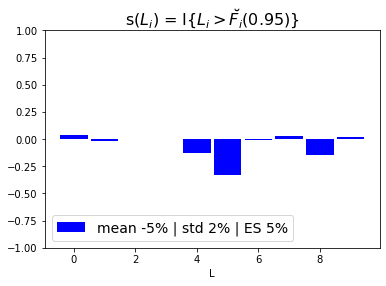

In [13]:
# Get sensitivity
sensitivity_measure_s = [StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x'])]

# Calculate sensitivities
sensitivity_measure_95 = [np.zeros(10)]
for k in range(10):
    # Get s:R->R
    s95 = lambda x: x > gamma.ppf(0.95, a=5, loc=25, scale=0.2 * (k + 1))
    sensitivity_measure_95[0][k] = StressModel.reverse_sensitivity_measure(s95, StressModel.data['x'][:, k])

labels = [f'mean {mean_stress}% | std {std_stress}% | ES {rm_stress}%']
colors = ['blue']

# Plot sensitivities
StressModel.plot_sensitivities(sensitivity_measure_s, filename= filename + '_sensitivity.pdf',
                               labels=labels, colors=colors, title=r's($L_i$)=$L_i$', save=False)
StressModel.plot_sensitivities(sensitivity_measure_95, filename= filename + '_sensitivity.pdf',
                               labels=labels, colors=colors, title=r's($L_i$) = I{$L_i > \breve{F_i}(0.95)$}', save=False)

### 3c. Example: Stress HARA utility + ES risk measure

#### The HARA Utility

The Hyperbolic absolute risk aversion (HARA) utility function is defined by $u(x) = \frac{1 - \eta}{\eta}(\frac{ax}{1-\eta} + b)^{\eta}$. We choose parameters $\eta = 0.5$, $\alpha = 1$ and $b = 5$, which guarantees concavity. $u(x)$ is plotted below.

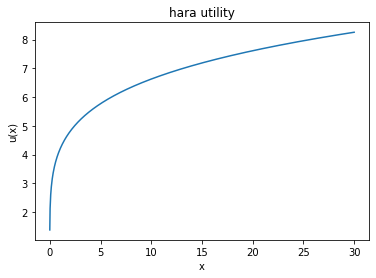

In [14]:
# Define hara parameters
a = 1
eta = 0.5
b = lambda eta: 5 * (eta / (1 - eta)) ** (1 / eta)

# Define hara function and plot
hara = lambda a, b, eta, x: (1 - eta) / eta * (a * x / (1 - eta) + b) ** eta
x = np.linspace(1e-20, 30, 1000)
plt.plot(x, hara(1, b(0.2), 0.2, x))
plt.title('hara utility')
plt.ylabel('u(x)')
plt.xlabel('x')
plt.show()

#### The Stressed Distribution

We apply a $1\%$ stress to the ${ES}_{0.80}$, $3\%$ stress to the ${ES}_{0.95}$, and a $1\%$ stress to the HARA utility. We plot first, the stressed and baseline quantile functions of the output and second, the corresponding densities.

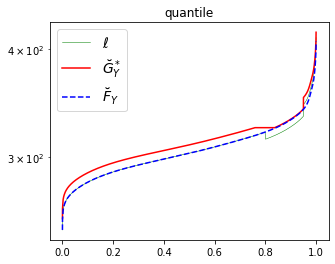

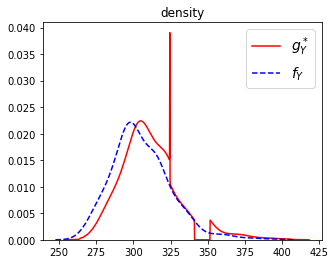

In [15]:
# Set alpha, gammas
alpha = [0.8, 0.95]
gammas = [lambda u: (u > alpha[0]) / (1 - alpha[0]), lambda u: (u > alpha[1]) / (1 - alpha[1])]
StressModel.set_gamma(gammas)

# Define stresses
utility_stress = 1
rm_stress = [1, 3]

# Get baseline risk measure and utility to be stressed
RM_P = StressModel.get_risk_measure_baseline()
Utility_P = StressModel.get_hara_utility(a, b(eta), eta, StressModel.u, StressModel.F_inv)

# Run optimization
_, _, _, fig = StressModel.optimise_HARA(a, b(eta), eta, Utility_P * (1 + utility_stress / 100),
                                             RM_P * np.array([1 + rm_stress[0] / 100, 1 + rm_stress[1] / 100]),
                                        title = 'quantile')

# Generate filename
filename = folder + f'hara-es/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}'

# Plot quantile function
display(fig)

# Plot result distributions
StressModel.plot_dist(filename, type="ES", title=f"density", cdf=False, save=False)

#### The Stressed Model

We examine how the stresses applied affects the distributions of the input parameters $L_2$ and $L_9$. We plot first, the stressed and baseline density functions of the input parameters and second, the contours for the stressed and baseline bivariate copulae of $(L_2, L_9)$, where the baseline contours are semi-transparent. 

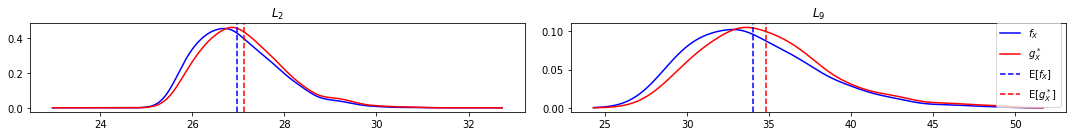

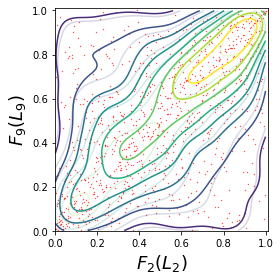

In [16]:
# Set (Li, Lj) to plot
i = 1
j = 8

# Plot density of Li, Lj
StressModel.plot_xdensity(filename, inputs = [i, j], save=False)

# Plot copula contours for selected (Li, Lj)
StressModel.plot_copula(i, j, filename + f'_copula_L{i}_L{j}.pdf', save=False)

#### Sensitivity Measures

We use $s(L_i) = L_i$, $s(L_i) = \mathbb{1}_{\{L_i > \breve{F_i}(0.80)\}}$ and $s(L_i) = \mathbb{1}_{\{L_i > \breve{F_i}(0.95)\}}$. The plots below show the reverse sensitivity measures for each input $L_i$ under the different $s$.

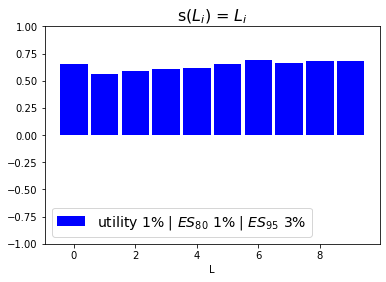

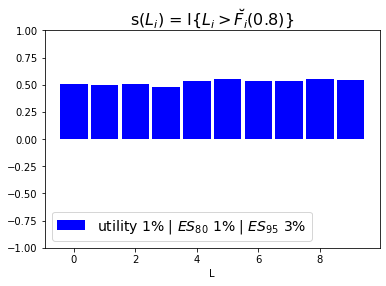

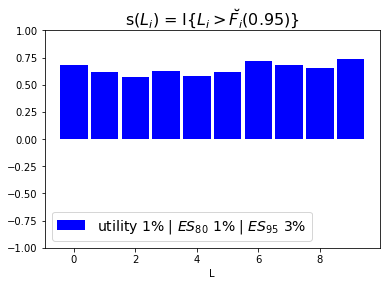

In [17]:
# Set (Li, Lj) to plot
i = 1
j = 8

colors = ['blue']

# Calculate sensitivity_measures
sensitivity_measures_s = [StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x'])]

sensitivity_measures_95 = [np.zeros(10)]
sensitivity_measures_80 = [np.zeros(10)]
for k in range(10):
    # Get s:R->R
    s95 = lambda x: x > gamma.ppf(0.95, a=5, loc=25, scale=0.2 * (k + 1))
    s80 = lambda x: x > gamma.ppf(0.8, a=5, loc=25, scale=0.2 * (k + 1))
    sensitivity_measures_95[0][k] = StressModel.reverse_sensitivity_measure(s95, StressModel.data['x'][:, k])
    sensitivity_measures_80[0][k] = StressModel.reverse_sensitivity_measure(s80, StressModel.data['x'][:, k])

labels = [f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%']

# Plot sensitivities
StressModel.plot_sensitivities(sensitivity_measures_s, labels=labels, colors=colors,
                           title=r's($L_i$) = $L_i$', save=False,
                           filename=folder + f'hara-es/data_ES_utility_sensitivity.pdf')
StressModel.plot_sensitivities(sensitivity_measures_80, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.8)$}', save=False,
                           filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_80.pdf')
StressModel.plot_sensitivities(sensitivity_measures_95, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.95)$}', save=False,
                           filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_95.pdf')